<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# 6.0 TTS Pipeline with NVIDIA NeMo
## (part of Lab 2)

In this notebook, you'll run a text-to-speech (TTS) pipeline to generate audio samples using NeMo's pretrained models.  We'll zoom in a bit to examine the steps,  including normalization, spectrogram generation, and vocoder.

**[6.1 Text Normalization](#6.1-Text-Normalization)<br>**
**[6.2 Grapheme to Phoneme Conversion (G2P)](#6.2-Grapheme-to-Phoneme-Conversion-(G2P))<br>**
&nbsp;&nbsp;&nbsp;&nbsp;[6.2.1 Pronunciation Dictionary](#6.2.1-Pronunciation-Dictionary)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.2.2 Run G2P](#6.2.2-Run-G2P)<br>
**[6.3 Spectrogram Generator](#6.3-Spectrogram-Generator)<br>**
&nbsp;&nbsp;&nbsp;&nbsp;[6.3.1 Load FastPitch](#6.3.1-Load-FastPitch)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.3.2 Run FastPitch](#6.3.2-Run-FastPitch)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.3.3 Customize the Pitch](#6.3.3-Customize-the-Pitch)<br>
**[6.4 Vocoder](#6.4-Vocoder)<br>**
&nbsp;&nbsp;&nbsp;&nbsp;[6.4.1 Load HiFiGAN](#6.4.1-Load-HiFiGAN)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.4.2 Run HiFiGAN Inference](#6.4.2-Run-HiFiGAN-Inference)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.4.3 Customize Audio Duration and Pitch](#6.4.3-Customize-Audio-Duration-and-Pitch)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.4.4 Exercise: Happy Emotion](#6.4.4-Exercise:-Happy-Emotion)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.4.5 Customize Phonemes](#6.4.5-Customize-Phonemes)<br>
**[6.5 Shut Down the Kernel](#6.5-Shut-Down-the-Kernel)<br>**

<img src="images/tts/tts_pipeline.png">

# 6.1 Text Normalization


As opposed to the inverse text normalization (ITN) process applied to the ASR pipeline, text normalization (TN) converts a written format to its verbalized form. This preprocessing step is necessary for the text-to-speech (TTS) pipeline.

For example, the TN module converts the standard textual measures format, *the height is 84.6cm*, to its verbalized form ,*the height is eighty four point six centimeters*.

The NeMo text normalizer uses two composite _weighted finite-state transducers_ (WFSTs):
- Classifier: Tag input into semiotic tokens (e.g. currency, ordinal number, street address)
- Verbalizer: Render a tagged token into conventional written form

Learn more about NeMo TN in the documentation: [NeMo Text Normalization](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/v1.0.0/nemo_text_processing/text_normalization.html).


In the next few cells, we load the TN for English and run the normalization on some text using the `nemo_text_processing.text_normalization.normalize.Normalizer.normalize` module.


In [1]:
from nemo_text_processing.text_normalization.normalize import Normalizer
text_normalizer = Normalizer(input_case="cased", lang="en")

[NeMo I 2023-07-27 07:21:01 tokenize_and_classify:87] Creating ClassifyFst grammars.


In [2]:
text = "Your total bill is $25.45"
normalized_text = text_normalizer.normalize(text)
print("Input text     : ", text)
print("Normalized text: ", normalized_text)

Input text     :  Your total bill is $25.45
Normalized text:  Your total bill is twenty five dollars forty five cents


In [3]:
text = "NVIDIA was founded in 04/05/1993, 29 years ago."
normalized_text = text_normalizer.normalize(text)
print("Input text     : ", text)
print("Normalized text: ", normalized_text)

Input text     :  NVIDIA was founded in 04/05/1993, 29 years ago.
Normalized text:  NVIDIA was founded in april fifth nineteen ninety three, twenty nine years ago.


In [4]:
text = "I am Mrs. Smith."
normalized_text = text_normalizer.normalize(text)
print("Input text     : ", text)
print("Normalized text: ", normalized_text)

Input text     :  I am Mrs. Smith.
Normalized text:  I am misses Smith.


It is also possible to output the details of tagged text provided by the TN model by setting the `verbose=True` argument.

In [5]:
text = "Your total bill is $25.45"

normalized_text = text_normalizer.normalize(text,verbose=True)

tokens { name: "Your" } tokens { name: "total" } tokens { name: "bill" } tokens { name: "is" } tokens { money { integer_part: "twenty five" currency_maj: "dollars" fractional_part: "forty five"  currency_min: "cents" preserve_order: true } }


# 6.2 Grapheme to Phoneme Conversion (G2P)

For text representation, TTS pipelines use phonemes (small units of the sound) as representations instead of graphemes (orthographic symbols). 
This is because phonemes are a richer representation for speech synthesis as they include pronunciation information. There are different phonetic representation standards supporting English (among others) such as [ARPAbet](https://en.wikipedia.org/wiki/ARPABET) and [International Phonetic Alphabet (IPA)](https://en.wikipedia.org/wiki/International_Phonetic_Alphabet). 

For example: 
- Graphemes example: *"you have a cute dog"*
- IPA phonemes example: *"ˈju ˈhæv A ˈkjut ˈdɔɡ"*



## 6.2.1 Pronunciation Dictionary

Mapping between graphemes and phoneme for common words in a language can be specified where needed. A list of supported phonemes and IPA symbols can be found in the [Phoneme Support documentation] (https://docs.nvidia.com/deeplearning/riva/user-guide/docs/tts/tts-phones.html#phoneme-support).

Examples:
- NVIDIA   --> ɛnˈvɪdiə
- DECEMBER --> dɪˈsɛmbɚ

The dictionary can be extended with the new words and their corresponding desired pronunciation.

An extended version of the English IPA dictionary is included in this course instance. You can also find the dictionary on [NeMo Repository](https://raw.githubusercontent.com/NVIDIA/NeMo/main/scripts/tts_dataset_files/ipa_cmudict-0.7b_nv22.10.txt).

Let's first have a look the IPA dictionary.

In [6]:
# set the IPA dictionary 
IPA_DICTIONARY = "/opt/NeMo/scripts/tts_dataset_files/ipa_cmudict-0.7b_nv22.10.txt"

In [7]:
! grep 'JANUARY' $IPA_DICTIONARY

JANUARY  ˈdʒænjuˌɛɹi
JANUARY'S  ˈdʒænjuˌɛɹiz


In [8]:
! grep 'NVIDIA' $IPA_DICTIONARY

;;; Words added by NVIDIA
NVIDIA  ɛnˈvɪdiə
NVIDIA'S  ɛnˈvɪdiəz


## 6.2.2 Run G2P

Grapheme to phoneme conversion (G2P) converts graphemes to phonemes. 

Let's instantiate a G2P converter with NeMo using the `IPAG2P` module, which converts sentences from graphemes to IPA phoneme representations.

In [9]:
from nemo.collections.tts.torch.g2ps import IPAG2P

# instantiate G2P with our dictionary 
ipa = IPAG2P(phoneme_dict=IPA_DICTIONARY, use_stresses=False)

[NeMo W 2023-07-27 07:21:27 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-27 07:21:27 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-27 07:21:27 experimental:27] Module <class 'nemo_text_processing.g2p.modules.IPAG2P'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-27 07:21:28 modules:344] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.


In [10]:
input_string1 = "My name is Dana."

# Convert G2P
phonemes = ipa(input_string1)
print('Phonemes: ', ''.join(phonemes))

Phonemes:  maɪ neɪm IS deɪnə.


In English, phonemes of a word have the same level of pronunciation intensity (or stress). IPA support two stress symbol:
- `ˈ` primary stress symbol: the stronger phoneme of the word
- `ˌ` secondary stress symbol: moderately strong phoneme of the word

Use `use_stresses=True` to set G2P with stress symbols.


In [11]:
# instantiate G2P with stress symbols
ipa_stress = IPAG2P(phoneme_dict=IPA_DICTIONARY, use_stresses=True)

[NeMo W 2023-07-27 07:21:29 modules:344] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.


In [12]:
# Convert G2P with stress symbols
phonemes_stress = ipa_stress(input_string1)
print('Phonemes: ', ''.join(phonemes_stress))

Phonemes:  ˈmaɪ ˈneɪm IS ˈdeɪnə.


Let's now try with another example including a proper name with Polish pronunciation: *Grzywaczewski*.

In [13]:
input_string2 = "my name is Adam Grzywaczewski"

# Convert G2P with stress symbols
phonemes_stress = ipa_stress(input_string2)
print('Phonemes: ', ''.join(phonemes_stress))

Phonemes:  ˈmaɪ ˈneɪm IS ˈædəm GRZYWACZEWSKI


*Grzywaczewski* is an out-of-vocabulary word (OOV), meaning it is not part of the IPA dictionary. 

We can customize G2P models with OOV words, like proper names such as *Grzywaczewski*, to provide their phonetic form [*ɡzɪvɑˈtʃɛvski*] to improve the quality of the synthesized text.

# 6.3 Spectrogram Generator


<img src="images/tts/TTS_spec.png">
In the NeMo library, TTS models are defined under the `nemo.collections.tts.models` method. 

To load a TTS model, we can restore the parameters from a local `.nemo` model. 

Alternatively, pretrained models can be loaded from NVIDIA repository on NGC using the `from_pretrained(...)` method that downloads and initializes model directly from the cloud. To check the list of available pretrained models, please use the `list_available_models()` method.

NeMo support Tacotron2, GlowTTS, TalkNet, FastPitch, FastSpeech2, Mixer-TTS, and Mixer-TTS-X spectrogram generators. In this lab, we will explore the FastPitch spectrogram generator.

In [14]:
# Import relevant libraries
import IPython.display as ipd
import librosa
#import librosa.display
import numpy as np
import torch
from torchinfo import summary

from matplotlib import pyplot as plt
#from matplotlib.pyplot import imshow

%matplotlib inline


# Reduce logging messages for this notebook
#from nemo.utils import logging
#logging.setLevel(logging.ERROR)

from nemo.collections.tts.models import FastPitchModel
from nemo.collections.tts.models import HifiGanModel
from nemo.collections.tts.helpers.helpers import regulate_len

In [15]:
# display list of models
def display_list_available_models(model):
    print ( "list of available models:")
    for m in model.list_available_models():
        print ("   ", "\033[1;34m", m.pretrained_model_name)

Let's check the list of FastPitch models available in NeMo:

In [16]:
# check list of fastpitch models available
display_list_available_models(FastPitchModel)

list of available models:
     tts_en_fastpitch
     tts_en_fastpitch_ipa
     tts_en_fastpitch_multispeaker
     tts_de_fastpitch_singlespeaker
     tts_de_fastpitch_multispeaker_5
     tts_es_fastpitch_multispeaker
     tts_zh_fastpitch_sfspeech


## 6.3.1 Load FastPitch

FastPitch is a fully-parallel Transformer-based architecture with prosody control over pitch and phoneme duration. The model predicts pitch contours during inference that can be modified to add more expressiveness to the generated speech.

In this lab, we will use the English FastPitch model [`tts_en_fastpitch_ipa`](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/tts_en_fastpitch) that generates mel spectrograms from text input. This model is trained on the [LJSpeech dataset](https://keithito.com/LJ-Speech-Dataset/) sampled at 22050Hz, and has been tested on generating female English voices with an American accent.

Let's load the model and examine its architecture:

In [17]:
# load spectrogram generator
fastpitch = FastPitchModel.from_pretrained("tts_en_fastpitch_ipa").eval().cuda()
sample_rate = 22050

[NeMo I 2023-07-27 07:21:29 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_fastpitch/versions/IPA_1.13.0/files/tts_en_fastpitch_align_ipa.nemo to /root/.cache/torch/NeMo/NeMo_1.14.0/tts_en_fastpitch_align_ipa/63969a9d8c2d5f4870d16fbf8064a5e0/tts_en_fastpitch_align_ipa.nemo
[NeMo I 2023-07-27 07:21:38 common:912] Instantiating model from pre-trained checkpoint
[NeMo I 2023-07-27 07:21:41 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2023-07-27 07:22:07 modules:344] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2023-07-27 07:22:07 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /data3/LJSpeech/nvidia_ljspeech_train.json
      sample_rate: 22050
      sup_data_path: /data3/LJSpeech/tmp_ignoreamb/
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_durati

[NeMo I 2023-07-27 07:22:08 features:267] PADDING: 1
[NeMo I 2023-07-27 07:22:11 save_restore_connector:243] Model FastPitchModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.14.0/tts_en_fastpitch_align_ipa/63969a9d8c2d5f4870d16fbf8064a5e0/tts_en_fastpitch_align_ipa.nemo.


In [18]:
# plot fastpitch architecture 
summary(fastpitch)

Layer (type:depth-idx)                             Param #
FastPitchModel                                     --
├─MelLoss: 1-1                                     --
├─PitchLoss: 1-2                                   --
├─DurationLoss: 1-3                                --
├─EnergyLoss: 1-4                                  --
├─AlignmentEncoder: 1-5                            --
│    └─Softmax: 2-1                                --
│    └─LogSoftmax: 2-2                             --
│    └─Sequential: 2-3                             --
│    │    └─ConvNorm: 3-1                          885,504
│    │    └─ReLU: 3-2                              --
│    │    └─ConvNorm: 3-3                          61,520
│    └─Sequential: 2-4                             --
│    │    └─ConvNorm: 3-4                          38,560
│    │    └─ReLU: 3-5                              --
│    │    └─ConvNorm: 3-6                          12,880
│    │    └─ReLU: 3-7                              --
│    │

Check the number of parameters this FastPitch model has!

## 6.3.2 Run FastPitch

Let's generate the mel spectrograms of an input text string with FastPitch. 

The FastPitch inference function takes as input the tokenized text. So let's first generate the tokenized version of a text string using `fastpitch.parse()` model.  

In [19]:
input_string = "My name is Dana and I work for NVIDIA."

# Normalize the text and convert it into individual phonemes/tokens.
tokens= fastpitch.parse(input_string, normalize=True)
print(tokens)

tensor([[93, 90, 60, 50, 84, 93, 90, 61, 53, 84, 60, 93, 30, 40, 93, 90, 52, 53,
         84, 61, 79, 93, 22, 35, 25, 93, 90, 50, 84, 93, 90, 68, 82, 58, 93, 27,
         36, 39, 93, 81, 61, 90, 67, 84, 52, 56, 79,  7, 93]], device='cuda:0')


Let's run the FastPitch inference to generate the mel spectrograms. In the following cell, we define the `text_to_spectrogram` function to run inference and display function for the generated mel spectrograms and the predicted pitch and duration used to generate the mel spectrograms.

In [20]:
# Run FastPitch inference
def text_to_spectrogram(inp, pace=1.0, durs=None, pitch=None):
    with torch.no_grad():
        tokens = fastpitch.parse(inp)
        spec, _, durs_pred, _, pitch_pred, *_ = fastpitch(text=tokens, durs=durs, pitch=pitch, speaker=None, pace=pace)
    return spec, durs_pred, pitch_pred

# Plot mel spectrogram
def plot_spectrogram(spec):
    # Plot the spectrogram
    fig=plt.figure(figsize=(15,5))
    fig.suptitle('Mel-Spectrogram', fontsize=20)
    _ = plt.pcolormesh(spec[0].cpu().numpy(), cmap='viridis')

# plot the pitch
def plot_pitch(pitch, durs):
    # FastPitch predicts one pitch value per token. To plot it, we have to expand the token length to the spectrogram length
    pitch_pred, _ = regulate_len(durs, pitch.unsqueeze(-1))
    pitch_pred = pitch_pred.squeeze(-1)
    fig, ax = plt.subplots(figsize=(15, 5))
    #ax.title.set_text('Pitch', fontdict = {'font.size':22})
    fig.suptitle('Pitch', fontsize=20)
    ax.plot(pitch_pred.cpu().numpy()[0], color='blue', linewidth=1)

# Plot aligned mel spectrogram and pitch
def plot_spectrogram_pitch(spec, pitch, durs):
    # FastPitch predicts one pitch value per token. To plot it, we have to expand the token length to the spectrogram length
    pitch_pred, _ = regulate_len(durs, pitch.unsqueeze(-1))
    pitch_pred = pitch_pred.squeeze(-1)
    pitch_pred = pitch_pred + 6
    fig, ax = plt.subplots(figsize=(15, 5))
    fig.suptitle('Alligned Mel-Spectrogram and Pitch', fontsize=20)
    ax.plot(pitch_pred.cpu().numpy()[0], color='blue', linewidth=1, alpha=0.5)
    _ = plt.pcolormesh(spec[0].cpu().numpy(), cmap='viridis', alpha=0.5)

In [21]:
# Let's run FastPitch
spec_pred, durs_pred, pitch_pred = text_to_spectrogram(input_string)

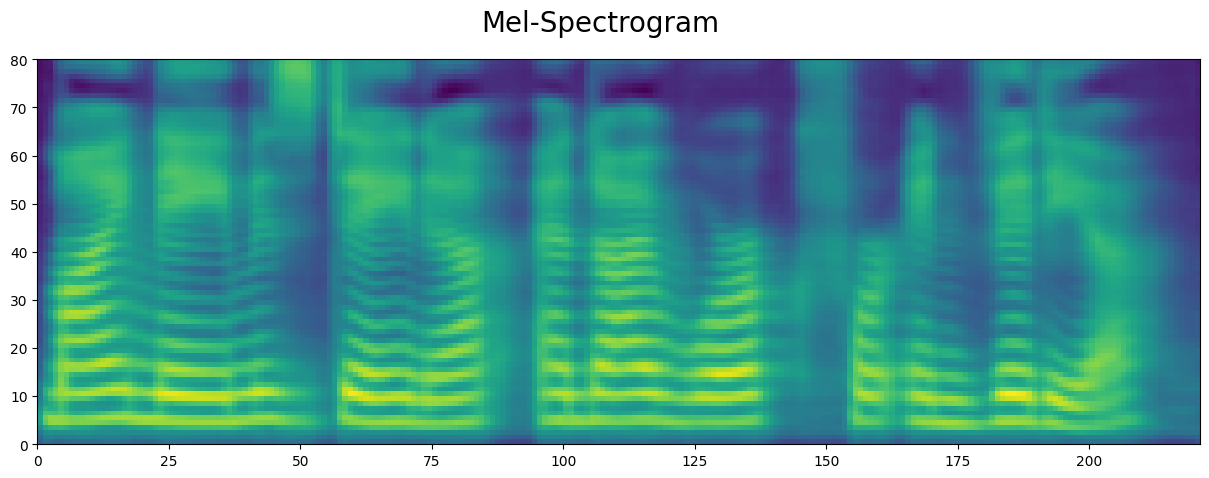

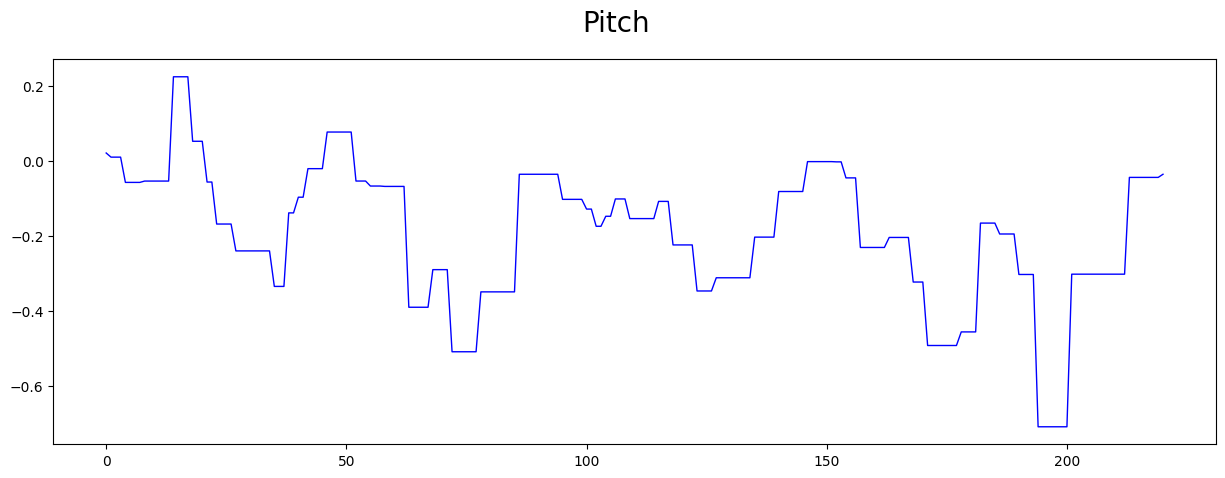

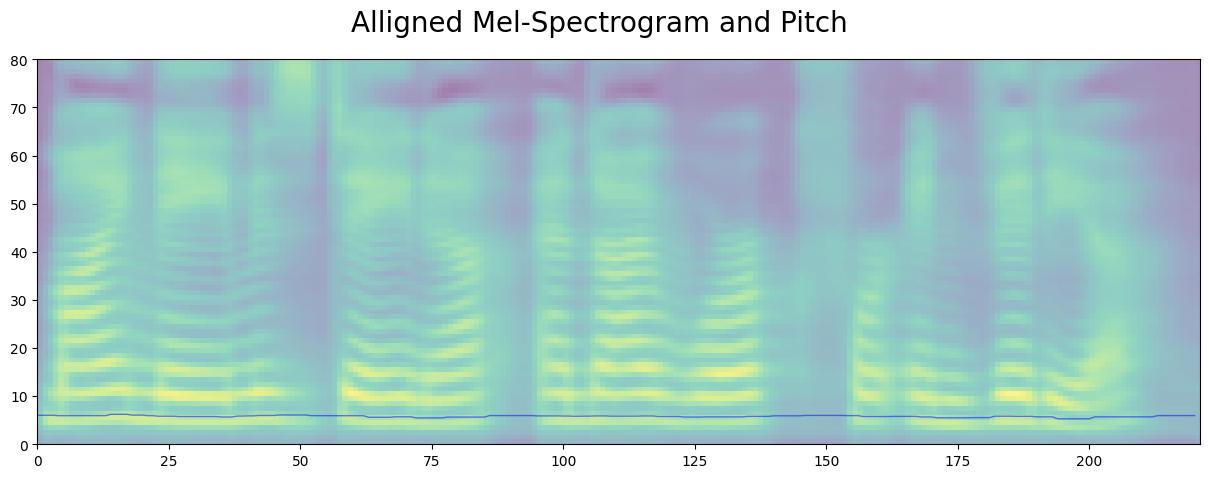

In [22]:
# Plot mel spectrogram  
plot_spectrogram(spec_pred)

# Plot the pitch
plot_pitch(pitch_pred, durs_pred)

# Plot alligned mel spectrogram and pitch
plot_spectrogram_pitch(spec_pred, pitch_pred, durs_pred)

## 6.3.3 Customize the Pitch
To customize the pitch and phoneme's durations, we can operate directly on the pitch and duration vectors before generating the mel spectrogram. 

Let's flatten the pitch and visualize the effect of this operation on the generated mel spectrogram.


In [23]:
# flatten the pitch
pitch_flat = pitch_pred * 0
# Now we can pass it to the model
spec_flat, durs_flat_pred, pitch_flat_pred = text_to_spectrogram(input_string, pitch=pitch_flat)

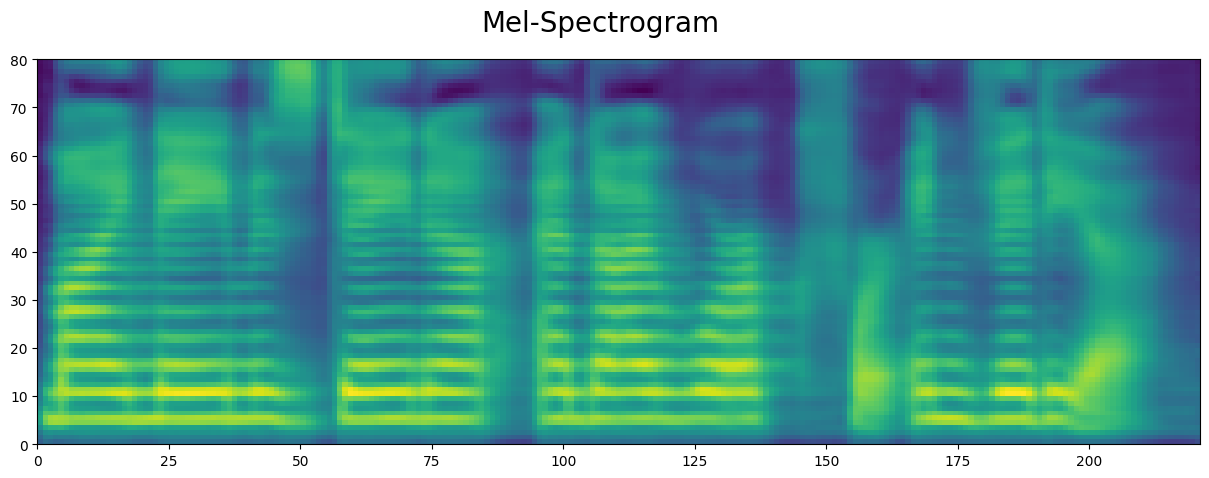

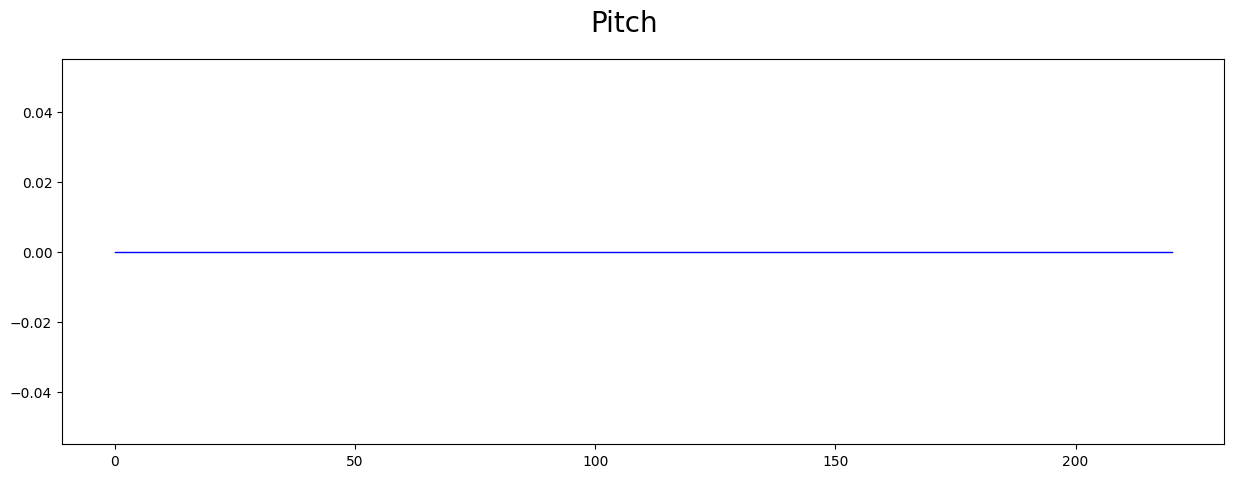

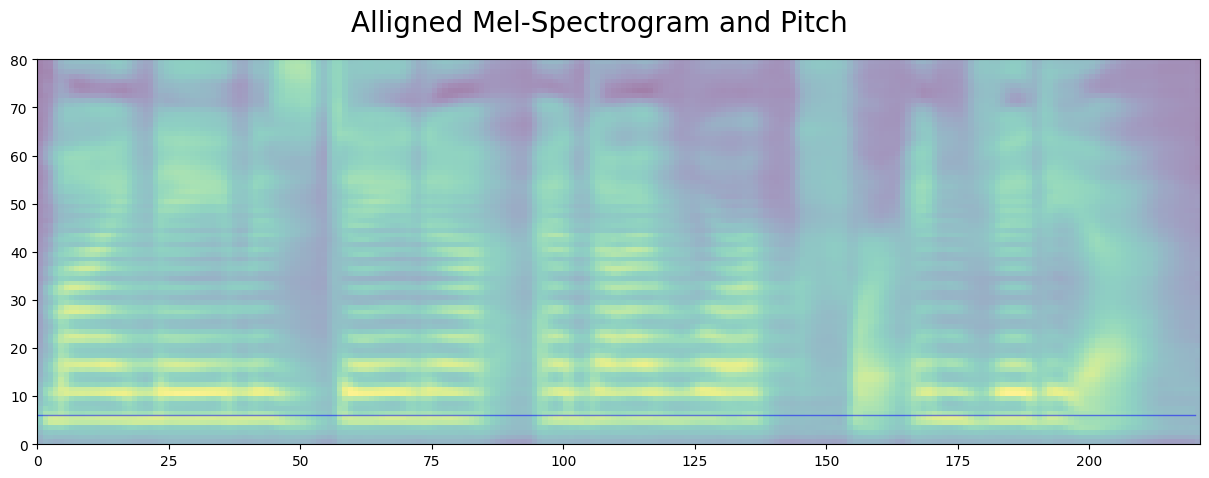

In [24]:
# Plot mel spectrogram  
plot_spectrogram(spec_flat)

# Plot the pitch
plot_pitch(pitch_flat, durs_pred)

# Plot alligned mel spectrogram and pitch
plot_spectrogram_pitch(spec_flat, pitch_flat, durs_pred)


# 6.4 Vocoder

NeMo supports WaveGlow, SqueezeWave, UniGlow, MelGAN, HiFiGAN, UnivNet, Tacotron2, and RadTTS vocoders. In this lab, we will explore the HiFiGAN vocoder.

Let's check the available HiFiGAN models:

In [25]:
display_list_available_models(HifiGanModel)

list of available models:
     tts_hifigan
     tts_en_lj_hifigan_ft_mixertts
     tts_en_lj_hifigan_ft_mixerttsx
     tts_en_hifitts_hifigan_ft_fastpitch
     tts_de_slr_hifigan_ft_fastpitch_singlespeaker
     tts_de_hui_hifigan_ft_fastpitch_multispeaker_5
     tts_es_hifigan_ft_fastpitch_multispeaker
     tts_zh_hifigan_sfspeech


## 6.4.1 Load HiFiGAN

HiFiGAN is a generative adversarial network (GAN) model that generates audio from mel spectrograms. The architecture is based on transposed convolutions to upsample mel spectrograms to audio.


In this lab, we will use the HiFiGAN model [`tts_hifigan`](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/tts_hifigan) that generate audio from Mel-spectrograms. This model is trained on [LJSpeech dataset](https://keithito.com/LJ-Speech-Dataset/) sampled at 22050Hz, and has been tested on generating female English voices with an American accent. 

Let's load the model and examine its architecture:

In [26]:
# Load the models from NGC
hifigan = HifiGanModel.from_pretrained("tts_hifigan").eval().cuda()

[NeMo I 2023-07-27 07:22:13 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo to /root/.cache/torch/NeMo/NeMo_1.14.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2023-07-27 07:22:27 common:912] Instantiating model from pre-trained checkpoint


[NeMo W 2023-07-27 07:22:29 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2023-07-27 07:22:29 modelPT:149] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2023-07-27 07:22:29 features:267] PADDING: 0


[NeMo W 2023-07-27 07:22:29 features:244] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2023-07-27 07:22:29 features:267] PADDING: 0
[NeMo I 2023-07-27 07:22:30 save_restore_connector:243] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.14.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


In [27]:
summary(hifigan)

Layer (type:depth-idx)                        Param #
HifiGanModel                                  --
├─FilterbankFeatures: 1-1                     --
├─FilterbankFeatures: 1-2                     --
├─Generator: 1-3                              --
│    └─Conv1d: 2-1                            287,744
│    └─ModuleList: 2-2                        --
│    │    └─ConvTranspose1d: 3-1              2,097,920
│    │    └─ConvTranspose1d: 3-2              524,672
│    │    └─ConvTranspose1d: 3-3              32,960
│    │    └─ConvTranspose1d: 3-4              8,288
│    └─ModuleList: 2-3                        --
│    │    └─ModuleList: 3-5                   8,266,752
│    │    └─ModuleList: 3-6                   2,068,992
│    │    └─ModuleList: 3-7                   518,400
│    │    └─ModuleList: 3-8                   130,176
│    └─Conv1d: 2-4                            226
├─MultiPeriodDiscriminator: 1-4               --
│    └─ModuleList: 2-5                        --
│    │    └─Dis

## 6.4.2 Run HiFiGAN Inference

Let's now generate speech synthesis from the spectrogram generated by the FastPitch mel spectrogram generator.

The `spectrogram_to_audio` function uses the NeMo `hifigan.convert_spectrogram_to_audio` module to generate the speech.


In [28]:
def spectrogram_to_audio(spec):
    with torch.no_grad():
        audio = hifigan.convert_spectrogram_to_audio(spec=spec).to('cpu').numpy()
    return  audio

Generate speech synthesis steps: 
- Generate the mel spectrogram from the input text using `text_to_spectrogram`
- Generate audio from the mel spectrogram using `spectrogram_to_audio`

In [29]:
input_string = "My name is Dana and I work for NVIDIA"

# FastPitch mel spectrogram generator
spec_pred, durs_pred, pitch_pred = text_to_spectrogram(input_string)  

# HiFiGAN audio generator
audio_pred=spectrogram_to_audio(spec_pred)
    
# Display generated speech sythesis
ipd.display(ipd.Audio(audio_pred, rate=22050))

Cool! 

## 6.4.3 Customize Audio Duration and Pitch

We can customize the duration and pitch of the mel spectrogram to modify speech synthesis. 

We'll start with duration. The pace value of the speaker can be specified to the spectrogram generator. Higher values result in a faster speaking pace.
   

In [30]:
# Durations 
fast_pace=1.5
slow_pace=0.8

# Fast speech
spec_pred_fast, durs_pred, pitch_pred = text_to_spectrogram(input_string, pace=fast_pace)  

audio_fast=spectrogram_to_audio(spec_pred_fast)
print("Fast Speech:")
ipd.display(ipd.Audio(audio_fast, rate=22050))
    
# Slow speech
spec_pred_slow, durs_pred, pitch_pred = text_to_spectrogram(input_string, pace=slow_pace) 

audio_slow=spectrogram_to_audio(spec_pred_slow)
print("Slow Speech:")
ipd.display(ipd.Audio(audio_slow, rate=22050))

Fast Speech:


Slow Speech:


Next, modify the pitch by generating audio with higher, lower, and flat pitch.

In [31]:
# Pitch cutomization
pitch_higher=pitch_pred+1.0
pitch_lower=pitch_pred-1.0
pitch_flat = pitch_pred * 0

# Higher speech
spec_pred, durs_pred, pitch_pred = text_to_spectrogram(input_string,pitch=pitch_higher)  

audio_pred=spectrogram_to_audio(spec_pred)
print("Higher Pitch:")
ipd.display(ipd.Audio(audio_pred, rate=22050))

# Lower speech
spec_pred, durs_pred, pitch_pred = text_to_spectrogram(input_string,pitch=pitch_lower)  

audio_pred=spectrogram_to_audio(spec_pred)
print("Lower Pitch:")
ipd.display(ipd.Audio(audio_pred, rate=22050))

# Flat speech
spec_pred, durs_pred, pitch_pred = text_to_spectrogram(input_string,pitch=pitch_flat)  

audio=spectrogram_to_audio(spec_pred)
print("Flat Speech:")
ipd.display(ipd.Audio(audio, rate=22050))

Higher Pitch:


Lower Pitch:


Flat Speech:


Let's try another sentence and generate speech synthesis with a sadness emotion.
- Generate a vanilla speech synthesis
- Modify the pitch to add some sadness: We need to lower the pitch ($\times 0.75$)and shift it to the left ($-0.75$)
- Generate a new  speech synthesis


In [32]:
input_string_2 = "Oh, I'm very sorry for mispronouncing your name."

# Pitch cutomization for sad emotion

spec_pred, durs_pred, pitch_pred = text_to_spectrogram(input_string_2)
audio_pred=spectrogram_to_audio(spec_pred)
print("First Audio sample:")
ipd.display(ipd.Audio(audio_pred, rate=22050))

# sad speech 
pitch_sad = (pitch_pred)*0.75-0.75
spec_sad, durs_sad_pred, _ = text_to_spectrogram(input_string_2, pitch=pitch_sad)
audio_sad=spectrogram_to_audio(spec_sad)
print("Saddened Speech:")
ipd.display(ipd.Audio(audio_sad, rate=22050))   

First Audio sample:


Saddened Speech:


## 6.4.4 Exercise: Happy Emotion

Generate speech synthesis with happy emotion by customizing the pitch.
- Generate a vanilla speech synthesis
- Operate on the pitch to add some happiness. We need to make a higher pitch and shift it to the right.
- Generate a new speech synthesis

Change the <i><strong style="color:green;">#FIXME</strong></i>s in the cell below. If you get stuck, refer to the [solution](solutions/ex6.4.4.ipynb).

In [34]:
# Pitch cutomization for happy emotion

input_string_3 = "I'm very happy for you."

# Generate a vanilla speech synthesis
spec_pred, durs_pred, pitch_pred = text_to_spectrogram(input_string_3)

audio_pred=spectrogram_to_audio(spec_pred)
print("First Audio sample:")
ipd.display(ipd.Audio(audio_pred, rate=22050))

# Happy speech 
pitch_happy =  (pitch_pred)*1.1+1
spec_happy, durs_happy_pred, pitch_happy_pred = text_to_spectrogram(input_string_3, pitch=pitch_happy)

audio_happy=spectrogram_to_audio(spec_happy)
print("Happy Speech:")
ipd.display(ipd.Audio(audio_happy, rate=22050)) 

First Audio sample:


Happy Speech:


## 6.4.5 Customize Phonemes

Let's try with another example including a proper name with Polish pronunciation: *Grzywaczewski*.
Let's start by generating the speech synthesis.

In [35]:
input_string = "His name is Adam Grzywaczewski and he works for NVIDIA"

tokens = fastpitch.parse(input_string)
spec, _, durs_pred, _, pitch_pred, *_ = fastpitch(text=tokens, durs=None, pitch=None, speaker=None, pace=1.0)
audio=spectrogram_to_audio(spec)
print("First Audio sample:")
ipd.display(ipd.Audio(audio, rate=22050))
print("Tokens: ",tokens)

First Audio sample:


Tokens:  tensor([[93, 29, 30, 40, 93, 90, 61, 53, 84, 60, 93, 30, 40, 93, 90, 74, 52, 79,
         60, 93, 28, 39, 47, 46, 44, 22, 24, 47, 26, 44, 40, 32, 30, 93, 22, 35,
         25, 93, 90, 55, 56, 93, 90, 68, 82, 58, 64, 93, 27, 36, 39, 93, 81, 61,
         90, 67, 84, 52, 56, 79, 93]], device='cuda:0')


Bad pronunciation!

One IPA pronunciation of `Grzywaczewski` could be `ɡzɪvɑˈtʃɛvski`

So let's tokenize the customized IPA representation to get the preferred list of tokens representing `ɡzɪvɑˈtʃɛvski`
Then, simply replace in the original tokenized sentence the `Grzywaczewski` sequence of tokens by the new pronunciation tokens.

In [36]:
# load radTTS aligner to get tokenized 
from nemo.collections.tts.models import AlignerModel
aligner = AlignerModel.from_pretrained("tts_en_radtts_aligner_ipa")

[NeMo I 2023-07-27 07:25:12 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_radtts_aligner/versions/IPA_1.13.0/files/Aligner.nemo to /root/.cache/torch/NeMo/NeMo_1.14.0/Aligner/0cfa131db81f64e49f9c47f286991019/Aligner.nemo
[NeMo I 2023-07-27 07:25:13 common:912] Instantiating model from pre-trained checkpoint
[NeMo I 2023-07-27 07:25:15 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2023-07-27 07:25:40 modules:344] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2023-07-27 07:25:40 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      sample_rate: 22050
      sup_data_path: /raid/LJSpeech/aligner_train_supp/
      sup_data_types:
      - align_prior_matrix
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
   

[NeMo I 2023-07-27 07:25:40 features:267] PADDING: 1
[NeMo I 2023-07-27 07:25:40 save_restore_connector:243] Model AlignerModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.14.0/Aligner/0cfa131db81f64e49f9c47f286991019/Aligner.nemo.


In [37]:
# Tokenize the original customized IPA
tokens_original = aligner.tokenizer.encode_from_g2p(list('GRZYWACZEWSKI'))
tokens_preferred = aligner.tokenizer.encode_from_g2p(list('ɡzɪvɑˈtʃɛvski'))
print("\n=== Tokens===")
print("GRZYWACZEWSKI: ", tokens_original)
print("ɡzɪvɑˈtʃɛvski: ", tokens_preferred)


=== Tokens===
GRZYWACZEWSKI:  [93, 28, 39, 47, 46, 44, 22, 24, 47, 26, 44, 40, 32, 30, 93]
ɡzɪvɑˈtʃɛvski:  [93, 83, 69, 84, 67, 77, 90, 65, 86, 81, 67, 64, 58, 56, 93]


In [38]:
# Manipulate tensor to replace values for tokens_original with tokens_preferred
import torch
custom_tokens=tokens
print("Full original token string:",custom_tokens)

for counter in range(len(custom_tokens[0])): 
    sublist = custom_tokens[0][counter:counter+len(tokens_original)]
    if sublist.tolist() == tokens_original:
        print("Found it at {}".format(counter))
        tensor_before = custom_tokens[:,0:counter]
        tensor_sublist = custom_tokens[:,counter:counter+len(tokens_original)]
        tensor_after = custom_tokens[:,counter+len(tokens_original):]
        break
print("Before: {}".format(tensor_before))
print("Sublist: {}".format(tensor_sublist))
tensor_replacement = torch.tensor([tokens_preferred], device='cuda:0')
print("Replacement: {}".format(tensor_replacement))
print("After: {}".format(tensor_after))

new_tokens = torch.cat((tensor_before, tensor_replacement, tensor_after), dim=1, out=None)
print("Final token string: {}".format(new_tokens))

Full original token string: tensor([[93, 29, 30, 40, 93, 90, 61, 53, 84, 60, 93, 30, 40, 93, 90, 74, 52, 79,
         60, 93, 28, 39, 47, 46, 44, 22, 24, 47, 26, 44, 40, 32, 30, 93, 22, 35,
         25, 93, 90, 55, 56, 93, 90, 68, 82, 58, 64, 93, 27, 36, 39, 93, 81, 61,
         90, 67, 84, 52, 56, 79, 93]], device='cuda:0')
Found it at 19
Before: tensor([[93, 29, 30, 40, 93, 90, 61, 53, 84, 60, 93, 30, 40, 93, 90, 74, 52, 79,
         60]], device='cuda:0')
Sublist: tensor([[93, 28, 39, 47, 46, 44, 22, 24, 47, 26, 44, 40, 32, 30, 93]],
       device='cuda:0')
Replacement: tensor([[93, 83, 69, 84, 67, 77, 90, 65, 86, 81, 67, 64, 58, 56, 93]],
       device='cuda:0')
After: tensor([[22, 35, 25, 93, 90, 55, 56, 93, 90, 68, 82, 58, 64, 93, 27, 36, 39, 93,
         81, 61, 90, 67, 84, 52, 56, 79, 93]], device='cuda:0')
Final token string: tensor([[93, 29, 30, 40, 93, 90, 61, 53, 84, 60, 93, 30, 40, 93, 90, 74, 52, 79,
         60, 93, 83, 69, 84, 67, 77, 90, 65, 86, 81, 67, 64, 58, 56, 93,

In [39]:
spec, _, durs_pred, _, pitch_pred, *_ = fastpitch(text=new_tokens, durs=None, pitch=None, speaker=None, pace=1.0)
audio_sad=spectrogram_to_audio(spec)
print("Customized Phonemes sample:")
ipd.display(ipd.Audio(audio_sad, rate=22050))    

Customized Phonemes sample:


---
# 6.5 Shut Down the Kernel
<h3 style="color:red;">Important!</h3>

From the menu above, choose ***Kernel->Shut Down Kernel*** to fully clear GPU memory before moving on.

---
<h2 style="color:green;">Congratulations!</h2>

In this notebook, you have:
- Normalized written text to speech-appropriate text
- Converted graphemes to phonemes
- Used the FastPitch model to create a spectrograph
- Converted spectrograms to audio with the HiFiGAN vocoder model
- Customized speech output

Next, you'll deploy the model on Riva. Move on to [TTS Pipeline Deployment with Riva](007_TTS_Deployment.ipynb).

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>